# IMEX-RB: A Fast and Stable Time Integration Method


In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from src.imexrb import imexrb
from src.euler import backward_euler, forward_euler
from src.problemsPDE import Heat2D
import utils.mpl_pubstyle
from utils.errors import compute_errors
from utils.helpers import *

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)

## Solving a 2D Heat Equation

We want to solve the 2D heat equation on the interval $x \in [0, L]$, $t > 0$:
---

We can now integrate in time, to show the performance of IMEX-RB compared to classic 1st order integration schemes, i.e. Backward/Forward Euler.

In [8]:
problem_name = "Heat2D"
Lx = 2
Ly = 2

Nx = 100
Ny = 100

mu = 0.02
sigma = 0.1
center = [1, 1]

t0 = 0.0
tf = 1.0
tspan = [t0, tf]

# Define the problem object
problem = Heat2D(Nx, Ny, Lx, Ly, mu=mu, sigma=sigma, center=center)
u0 = problem.initial_condition()


We now integrate over time, using different schemes. First of all, we define some parameters for the time integration

In [9]:
# Define number of timesteps
Nt = 100
# Define epsilon for absolute stability condition
epsilon = 1e-4  # 1.0 / cond_sparse(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(problem.Nh, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

Let us have a look at the selected dimension for the subspace $\mathcal{V}_n$

In [10]:
print(f"The subspace has an initial dim = {maxsize}, and such dim can grow up to {maxsize + maxsubiter}"
      f"\nThe full order problem has dim = {problem.Nh}")

The subspace has an initial dim = 22, and such dim can grow up to 44
The full order problem has dim = 10000


We compute the number of timesteps making forward Euler stable, for comparison with the other schemes

In [ ]:
Nt_FE = compute_steps_stability_FE(problem, tspan)

In [11]:
# First, IMEX-RB
uIMEX, tvec, subiter = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
uBE, _ = backward_euler(problem, u0, tspan, Nt)
# Forward Euler may throw errors if unstable
# uFE, tvecFE = forward_euler(problem, u0, tspan, Nt_FE)

18:43:37 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/100


### Compute and plot errors
We plot the errors over time for the previously chosen parameters. Note that the stability requirement for FE make it significantly more precise than BE and IMEX-RB, which attain stability for a much larger $\Delta t$

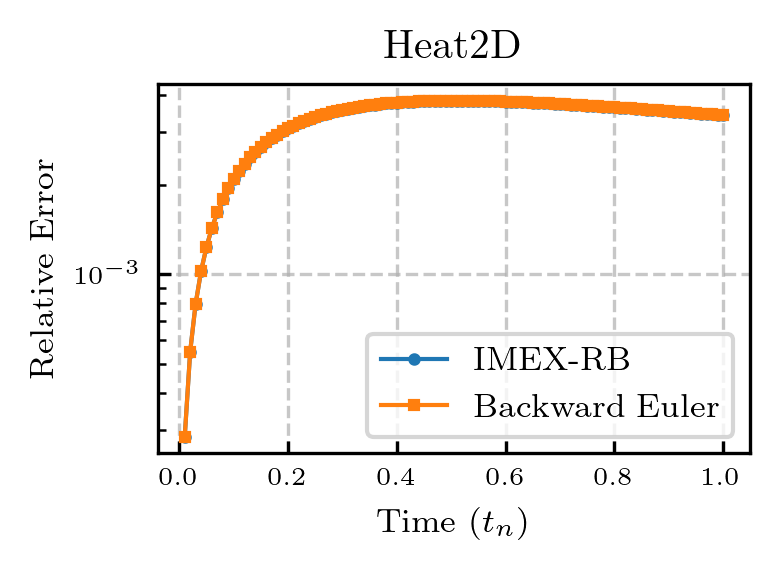

In [12]:
# Compute relative errors over time 
errIMEX = compute_errors(uIMEX, tvec, problem)
errBE = compute_errors(uBE, tvec, problem)
# errFE = compute_errors(uFE, tvecFE, problem)

# Plot the errors
plt.figure()
plt.semilogy(tvec[1:], errIMEX, label="IMEX-RB", marker='o')
plt.semilogy(tvec[1:], errBE, label="Backward Euler", marker='s')
# plt.semilogy(tvecFE[1:], errFE, label="Forward Euler (stable)", marker='^')

# Add labels, legend, and title
plt.xlabel(r"Time $(t_n)$")
plt.ylabel("Relative Error")
plt.title(f"{problem_name}")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Plot the animation of the solution
Note that an animated plot in jupyter is not straightforward, and that is why there are some weird commands

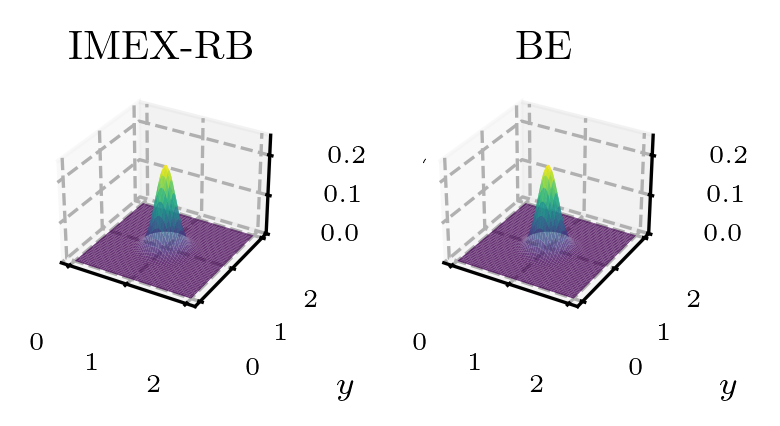

In [13]:
%matplotlib ipympl
from IPython import display
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Unpack meshgrid coords and shapes
X, Y = problem.coords
Nx, Ny = problem.shape

# Precompute global z‐limits from both methods over all time steps
zmin = min(uIMEX.min(), uBE.min())
zmax = max(uIMEX.max(), uBE.max())

# Setup figure with two 3D subplots
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
hdisplay = display.display("", display_id=True)

# Common formatting
for ax, title in [(ax1, "IMEX-RB"), (ax2, "BE")]:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$u$")
    ax.set_zlim(zmin, zmax)
    ax.set_title(title)

# Initialize empty surfaces
surf1 = ax1.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="viridis", alpha=0.8)
surf2 = ax2.plot_surface(X, Y, np.zeros((Nx, Ny)), cmap="viridis", alpha=0.8)

# Time‐loop: update each surface in turn
for n, t in enumerate(tvec[::10]):
    # remove old surfaces
    surf1.remove()
    surf2.remove()

    # reshape solution vectors
    Z1 = uIMEX[:, n].reshape((Nx, Ny))
    Z2 = uBE[:,   n].reshape((Nx, Ny))

    # re‐plot
    surf1 = ax1.plot_surface(X, Y, Z1, cmap="viridis", alpha=0.8)
    surf2 = ax2.plot_surface(X, Y, Z2, cmap="viridis", alpha=0.8)

    plt.suptitle(f"t = {t:.2f} s")

    # update display
    hdisplay.update(fig)
    # time.sleep(0.001)

plt.close(fig)


Go back to `matplotlib inline` (after animation)

In [ ]:
plt.close('all')
from IPython.display import clear_output
clear_output(wait=True)
%matplotlib inline

## Convergence test
We run a convergence test by computing the error at final time for different choices of $N_t$

In [16]:
# We now run a convergence test and plot the results
# Define the range of Nt values
Nt_values = np.array([2**n for n in range(4, 10)])
errors_imex = []
errors_be = []
# errors_fe = []

# Nt_FE_stable = compute_steps_stability_FE(problem, tspan)
# Loop over Nt values
for Nt in Nt_values:
    # Time discretization
    tvec = np.linspace(t0, tf, Nt + 1)
    dt = tvec[1] - tvec[0]

    # Solve the problem with each scheme
    uIMEX, *_ = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, 10)
    uBE, *_ = backward_euler(problem, u0, tspan, Nt)
    # uFE, *_ = forward_euler(problem, u0, tspan, Nt)

    # Compute errors at final time for each scheme
    err_imex = compute_errors(uIMEX, tvec, problem, mode="l2")
    err_be = compute_errors(uBE, tvec, problem, mode="l2")
    # err_fe = compute_errors(uFE, tvec, problem, mode="l2")

    # Store the final error
    errors_imex.append(err_imex)
    errors_be.append(err_be)
    # errors_fe.append(err_fe)


18:46:39 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/16
18:46:40 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/32
18:46:42 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/64
18:46:44 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/128
18:46:49 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/256
18:46:58 - src.imexrb - DEBUG - IMEX-RB: stability condition NOT met (times/total): 0/512


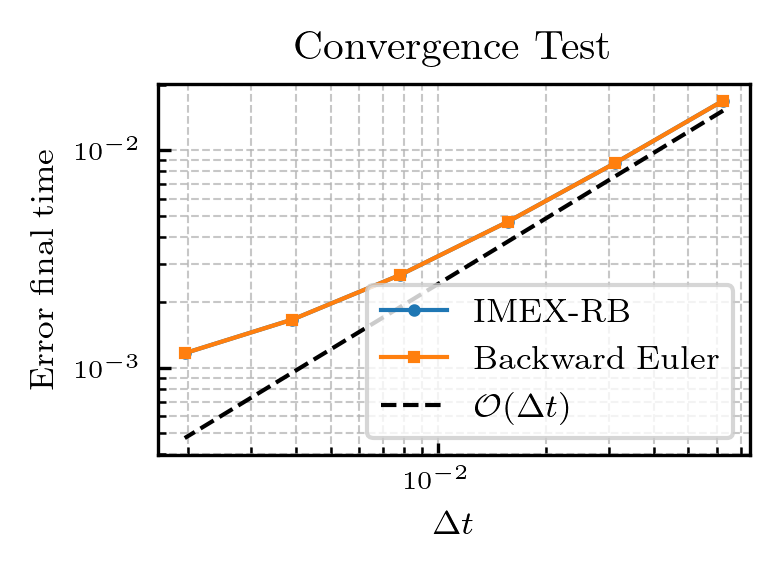

0.8997714042873043


In [20]:
# Plot the convergence results
plt.figure()
plt.loglog(1 / Nt_values, errors_imex, label="IMEX-RB", marker='o', linestyle='-')
plt.loglog(1 / Nt_values, errors_be, label="Backward Euler", marker='s', linestyle='-')
# plt.loglog(Nt_values, errors_fe, label="Forward Euler", marker='^', linestyle='-.')
# plt.axvline(Nt_FE_stable, label="Stability FE", color="r", linestyle='-.') 
plt.loglog(1 / Nt_values, (Nt_values[0] * errors_be[0] * 0.9) / Nt_values, 
           label=r"$\mathcal{O}(\Delta t)$", color="k", linestyle='--')

plt.xlabel(r"$\Delta t$")
plt.ylabel("Relative Error")
plt.title("Convergence Test")
plt.legend()
plt.grid(True, which="both", linewidth=0.5)
plt.show()

order = (np.log(errors_be[1:]) - np.log(errors_be[:-1])) / (np.log(1 / Nt_values[1:]) - np.log(1 / Nt_values[:-1]))
print(order[1])

### CPU Time to solution

We now compare the times required by IMEX-RB and BE to obtain a stable solution
N.W.: While we will keep $N_t$ fixed for IMEX-RB and BE, we will compute the $N_t$ making FE stable at each different problem size

In [ ]:
# Define number of timesteps
Nt = 200
# Define epsilon for absolute stability condition
epsilon = 1e-4 # 1.0/np.linalg.cond(problem.A)
# Define max dimension of subspace before subiterations
maxsize = int(np.ceil(np.pow(Nx, 1/3)))
# Define max allowed enlargement during subiterations
maxsubiter = maxsize

In [ ]:
# Parameters for the simulation
mu = 1.0
bc_left = 0.0
bc_right = 0.0
bc_bottom = 0.0
bc_top = 0.0
tspan = [0.0, 1.0]
Nt = 200           # Number of time steps for IMEX and BE

# Lists to store CPU times and errors
Nh_list = []
CPU_IMEX_list = []
CPU_BE_list = []
CPU_FE_list = []

err_IMEX_list = []
err_BE_list = []
err_FE_list = []

# Loop over different spatial resolutions
Nx_values = [2**val for val in range(4, 7)]
for Nx in Nx_values:
    # Define the problem object
    Ny = Nx
    problem = Heat2D(Nx, Ny, Lx, Ly, mu, bc_left, bc_right,
                    bc_bottom, bc_top)
    print(f"Running simulation for Nh = {problem.Nh}")
    Nh_list.append(problem.Nh)

    u0 = problem.initial_condition()
    epsilon = 1e-4  # tolerance parameter
    maxsize = int(np.ceil(np.power(Nx, 1/3)))
    maxsubiter = maxsize

    # Run IMEX-RB integration
    uIMEX, tvec, subiter, CPUtimeIMEX = imexrb(problem, u0, tspan, Nt, epsilon, maxsize, maxsubiter)
    # Run Backward Euler integration
    uBE, _, CPUTimeBE = backward_euler(problem, u0, tspan, Nt)
    # Run Forward Euler integration on its own stable time grid
    Nt_FE = compute_steps_stability_FE(problem, tspan)
    uFE, tvec_FE, CPUTimeFE = forward_euler(problem, u0, tspan, Nt_FE)

    # Compute errors at final time
    err_IMEX = compute_errors(uIMEX, tvec, problem, finaltimeonly=True)
    err_BE = compute_errors(uBE, tvec, problem, finaltimeonly=True)
    err_FE = compute_errors(uFE, tvec_FE, problem, finaltimeonly=True)

    # Append CPU times and errors
    CPU_IMEX_list.append(CPUtimeIMEX)
    CPU_BE_list.append(CPUTimeBE)
    CPU_FE_list.append(CPUTimeFE)

    err_IMEX_list.append(err_IMEX)
    err_BE_list.append(err_BE)
    err_FE_list.append(err_FE)


In [ ]:
# Plotting CPU times vs Nx
plt.subplot(2, 1, 1)
plt.loglog(Nh_list, CPU_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_list, CPU_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_list, CPU_FE_list, '^-', label='Forward Euler (stable)')
plt.xlabel(r'$N_h$')
plt.ylabel('CPU Time (s)')
# plt.title('CPU Time vs Spatial Resolution')
plt.legend()
plt.grid(True)

# Plotting errors at final time vs Nx
plt.subplot(2, 1, 2)
plt.loglog(Nh_list, err_IMEX_list, 'o-', label='IMEX-RB')
plt.loglog(Nh_list, err_BE_list, 's-', label='Backward Euler')
plt.loglog(Nh_list, err_FE_list, '^-', label='Forward Euler')
plt.xlabel(r'$N_h$')
plt.ylabel(r'Error')
# plt.title('Error vs num of unknowns')
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.show()

Once again Forward Euler is more precise because it is forced to use smaller $\Delta t$ s to meet stability requirements